# Setting up Environment

In [1]:
from AC import ACEnv

In [2]:
import numpy as np                              
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import gym
from gym import spaces
from statistics import median

In [4]:
import tf_slim as slim
from stable_baselines.common.policies import MlpPolicy, CnnLstmPolicy, MlpLstmPolicy, MlpLnLstmPolicy
from stable_baselines3 import PPO, DQN, A2C

# Functions

In [5]:
df = pd.read_csv("df.csv")
date_list = df.date.unique()
test = date_list[random.sample(range(len(date_list)), 30)]
df_train = df.loc[~df.date.isin(test)]
df_test = df.loc[df.date.isin(test)]

In [6]:
def plot_result_price(re, method):
    d = list(re.date.unique())
    fig, axes = plt.subplots(len(re.date.unique()),1,figsize = (15,15))
    plt.subplots_adjust(hspace = 0.5)
    
    for i in range(len(re.date.unique())):
        axe = axes[i].twinx()
        #axes[i].set_ylim(bottom = 0)
        axes[i].plot(re[re.date == d[i]].t, re[re.date == d[i]].price, color = 'grey', linestyle='dashed')
        axe.bar(re[re.date == d[i]].t, re[re.date == d[i]].net, color = 'skyblue', alpha=0.7)
        axe.plot(re[re.date == d[i]].t, re[re.date == d[i]].generation, color = 'orange')
        axe.plot(re[re.date == d[i]].t, re[re.date == d[i]].fixed, color = 'red')
        axes[i].grid()
        try:
            axes[i].title.set_text(method + '\n date: ' + d[i] + ' AC operation time: ' + str(re[(re.date == d[i]) & (re.consump_level > 0)].shape[0]))
        except:
            axes[i].title.set_text(method + '\n date: ' + d[i] + ' AC operation time: ' + 'No operation')
            
        axes[i].legend(['TOU price'], loc = 'upper left')
        axe.legend(['PV Generation', 'fixed', 'net_cost'], bbox_to_anchor=(1.2, 1.06), loc="upper right")
        plt.xticks(np.arange(0,24))
        net_E = re[re.date == d[i]].net
        level = re[re.date == d[i]].consump_level
        for j, v in enumerate(net_E):
            axe.text(j, v + .1, str(list(level)[j]), color='gray', fontweight='bold')
    plt.show()
        
def plot_result_temp(re, method):
    d = list(re.date.unique())
    fig, axes = plt.subplots(len(re.date.unique()),1,figsize = (15,15))
    plt.subplots_adjust(hspace = 0.5)
    
    for i in range(len(re.date.unique())):
        axe = axes[i].twinx()
        axes[i].plot(re[re.date == d[i]].t, re[re.date == d[i]].temp, color = 'green', linestyle='dashed')
        axe.plot(re[re.date == d[i]].t, re[re.date == d[i]].generation, color = 'orange')
        axe.plot(re[re.date == d[i]].t, re[re.date == d[i]].fixed, color = 'red')
        axe.bar(re[re.date == d[i]].t, re[re.date == d[i]].net, color = 'skyblue', alpha=0.7)
        axes[i].grid()
        try:
            axes[i].title.set_text(method + '\n date: ' + d[i] + ' AC operation time: ' + str(re[(re.date == d[i]) & (re.consump_level > 0)].shape[0]))
        except:
            axes[i].title.set_text(method + '\n date: ' + d[i] + ' AC operation time: ' + 'No operation')
            
        axes[i].legend(['Temperature'], loc = 'upper left')
        axe.legend(['PV Generation', 'fixed', 'net_cost'], bbox_to_anchor=(1.2, 1.06), loc="upper right")
        plt.xticks(np.arange(0,24))
        net_E = re[re.date == d[i]].net
        level = re[re.date == d[i]].consump_level
        for j, v in enumerate(net_E):
            axe.text(j, v + .1, str(list(level)[j]), color='gray', fontweight='bold')
    plt.show()

# Baseline Model

The baseline for AC is relatively simple as well. Given the customer’s preferred temperature range, the
baseline model logic is if the room temperature is outside of the preferred range, the AC will be turned
on by energy consumption level 2 for an hour; if the room temperature is within the range, the AC
will not be turned on. By doing so, it satisfies the requirements that it only run towards customer’s
preferred temperature range.

Comparing the tuned PPO with the baseline model, the average total energy cost has reduced 40.04%,
and the electricity bill has reduced 50.78%, which are significant improvements. Also, based on the
temperature adjustment plot, both baseline model and the PPO perform stabilized temperature ad-
justments towards the customer’s preferred temperature range. One could conclude that the PPO
could act as a relatively smart agent to give reducible appliances like AC reasonable action commands.
4 Conclusion

In [7]:
def baseline(env, temp_max, temp_min):
    date, time, price, temp, fixed_cost, net_cost, en_cost, generation, consump_level, total_en = [],[],[],[],[],[],[],[],[],[],
    for episode in range(5):
        s = env.reset()
        while True:
            if env.temp > temp_max or env.temp < temp_min:
                action = 2
            else:
                action = 0
            s_, rewards, done, info = env.step(action)
            date.append(env.cur_date)
            time.append(env.time)
            price.append(env.price)
            temp.append(env.temp)
            fixed_cost.append(env.fixed_cost)
            net_cost.append(env.net_energy_cost)
            en_cost.append(env.energy_cost)
            generation.append(env.generation)
            consump_level.append(env.action)
            s = s_
            if done:
                total_en.append(env.total_energy_cost)
                break
    re = pd.DataFrame({'date':date, 't':time, 'consump_level':consump_level ,'energy_cost':en_cost, 'fixed': fixed_cost,
                   'generation':generation, 'price':price, 'temp':temp })
    re['net'] = re.energy_cost + re.fixed - re.generation
    re['net'] = re['net'].apply(lambda x: 0 if x < 0 else x)
    return re

In [8]:
baseline_env = ACEnv(df=df_test, 
            mode="testing",
            penalty_temp=0.2, 
            penalty_energy=0.5, 
            penalty_ope=0.2, 
            prefered_temp_min=80, 
            prefered_temp_max=85, 
            max_limit=1000)

re_baseline = baseline(baseline_env, temp_max=85, temp_min=80)

In [9]:
baseline_ec = np.mean(re_baseline.energy_cost)
baseline_eb = np.mean(re_baseline.energy_cost*re_baseline.price)

# PPO

In [16]:
def predict(model, env):
    date, time, price, temp, fixed_cost, net_cost, en_cost, generation, consump_level, total_en = [],[],[],[],[],[],[],[],[],[],
    for episode in range(5):
        s = env.reset()
        while True:
            action, _states = model.predict(s)
            date.append(env.cur_date)
            time.append(env.time)
            price.append(env.price)
            temp.append(env.temp)
            fixed_cost.append(env.fixed_cost)
            net_cost.append(env.net_energy_cost)
            s_, rewards, done, info = env.step(action)
            en_cost.append(env.energy_cost)
            generation.append(env.generation)
            consump_level.append(env.action)
            s = s_
            if done:
                total_en.append(env.total_energy_cost)
                break
    re = pd.DataFrame({'date':date, 't':time, 'consump_level':consump_level ,'energy_cost':en_cost, 'fixed': fixed_cost,
                   'generation':generation, 'price':price, 'temp':temp })
    re['net'] = re.energy_cost + re.fixed - re.generation
    re['net'] = re['net'].apply(lambda x: 0 if x < 0 else x)
    return re
    

In [17]:
train_env = ACEnv(df=df_train, 
            mode="training",
            penalty_temp=0.2, 
            penalty_energy=0.5, 
            penalty_ope=0.2, 
            prefered_temp_min=80, 
            prefered_temp_max=85, 
            max_limit=1000)

ppo = PPO(policy='MlpPolicy', env=train_env, verbose=1) # MlpPolicy
ppo.learn(total_timesteps = 20000)

re_ppo_train = predict(ppo, train_env)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -782     |
| time/              |          |
|    fps             | 201      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24          |
|    ep_rew_mean          | -748        |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010063453 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [28]:
test_env = ACEnv(df=df_test, 
            mode="testing",
            penalty_temp=0.2, 
            penalty_energy=0.5, 
            penalty_ope=0.2, 
            prefered_temp_min=80, 
            prefered_temp_max=85, 
            max_limit=1000)
re_ppo_test = predict(ppo, test_env)

In [29]:
ppo_ec = np.mean(re_ppo_test.energy_cost)
ppo_eb = np.mean(re_ppo_test.energy_cost*re_baseline.price)
ec_improve = 100*(baseline_ec-ppo_ec)/baseline_ec
eb_improve = 100*(baseline_eb-ppo_eb)/baseline_eb
print(f'Total energy cost for PPO improved {ec_improve:.2f}% from baseline')
print(f'Total electricity bill for PPO improved {eb_improve:.2f}% from baseline')

Total energy cost for PPO improved 42.53% from baseline
Total electricity bill for PPO improved 44.50% from baseline


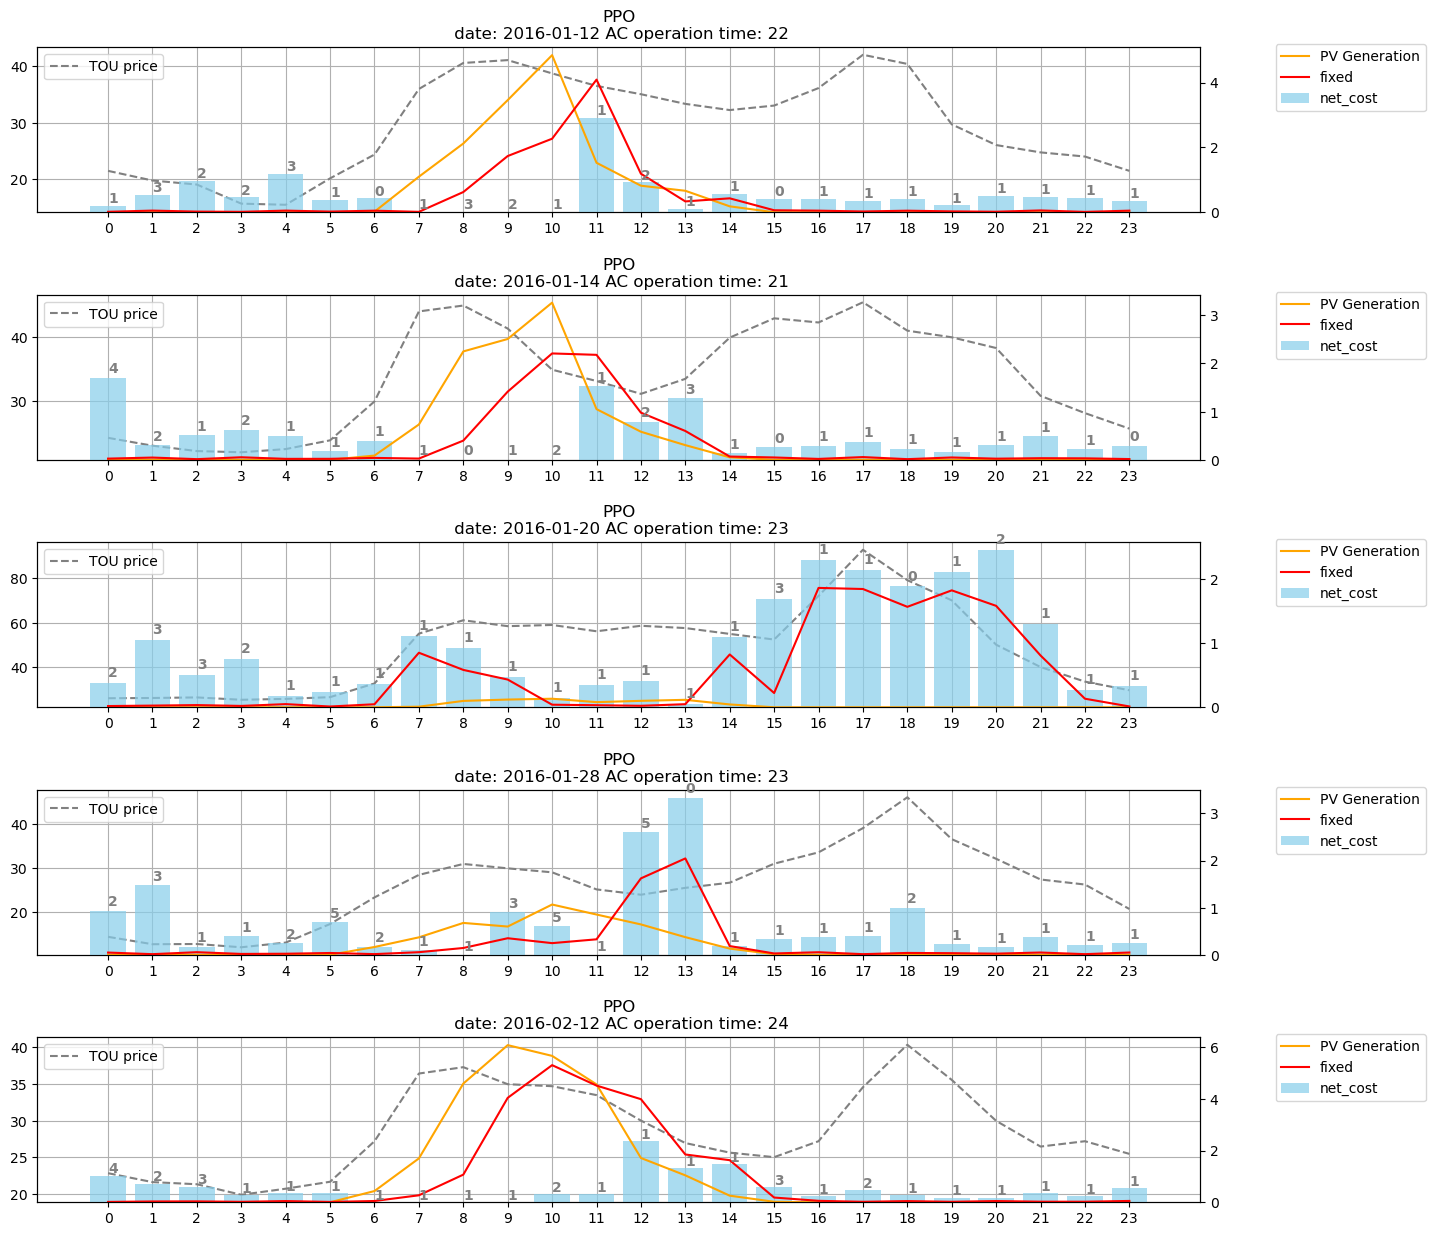

In [30]:
plot_result_price(re=re_ppo_test, method="PPO")

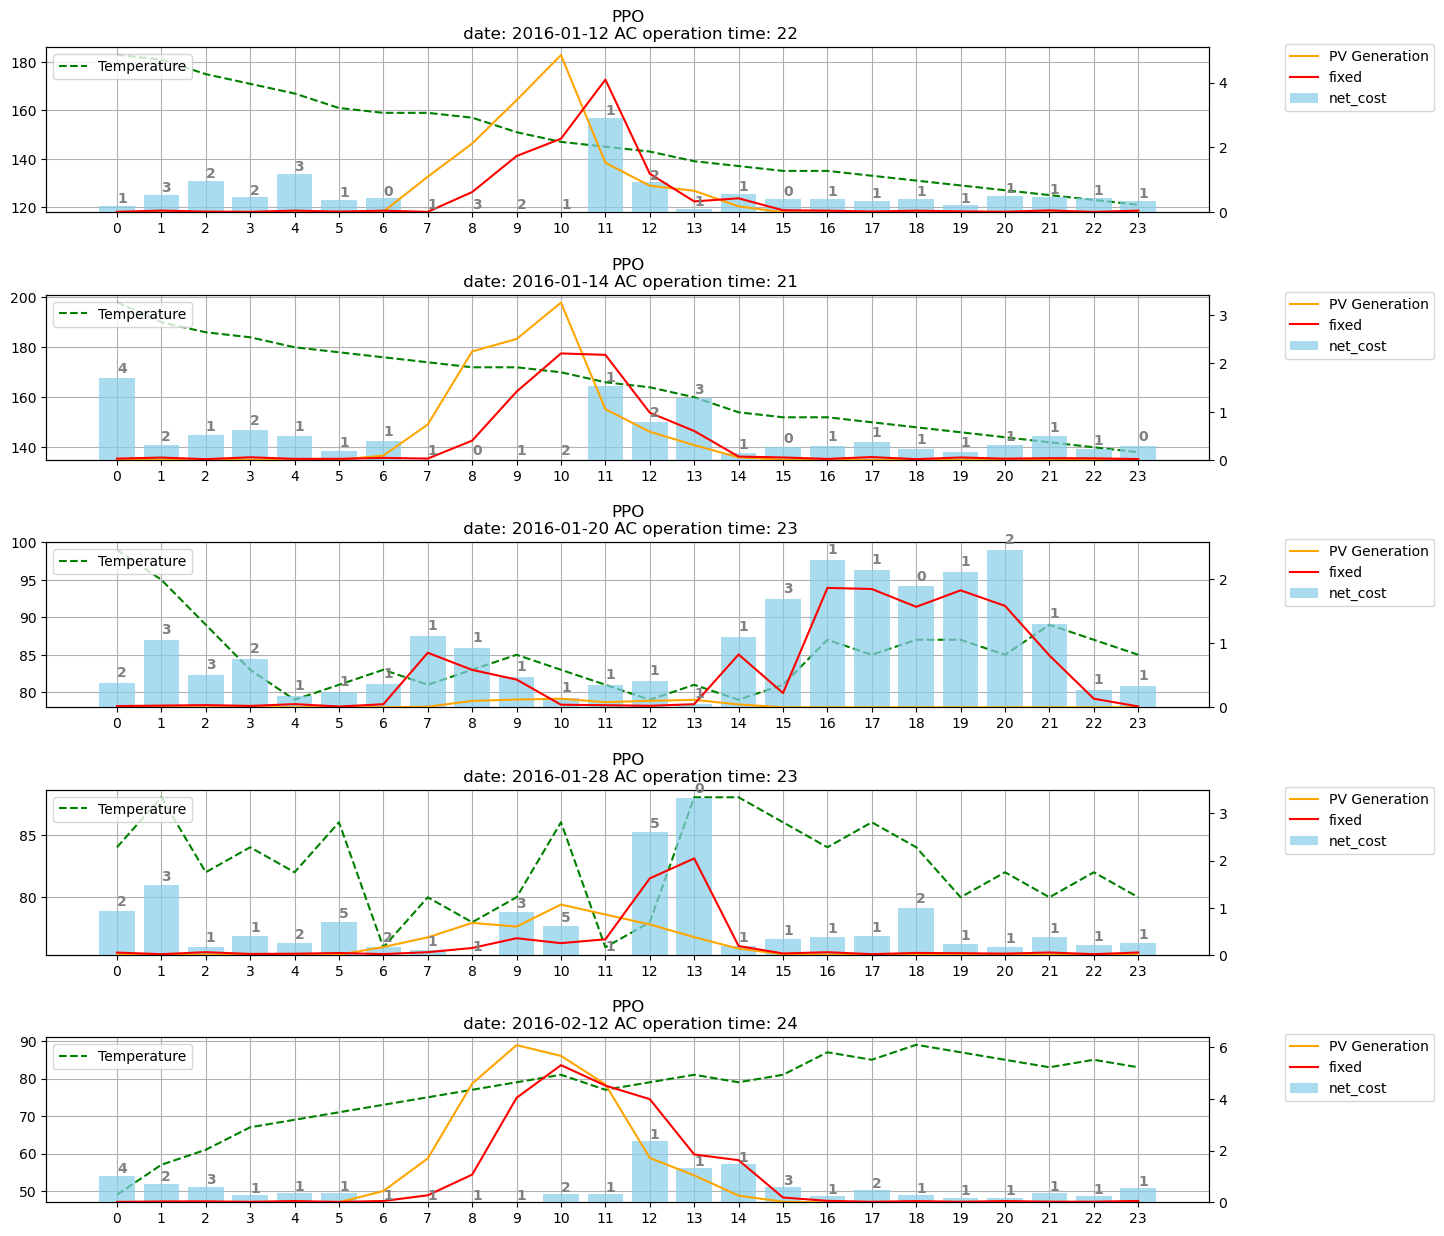

In [31]:
plot_result_temp(re=re_ppo_test, method="PPO")

# DQN

In [22]:
train_env = ACEnv(df=df_train, 
            mode="training",
            penalty_temp=0.2, 
            penalty_energy=0.5, 
            penalty_ope=0.2, 
            prefered_temp_min=80, 
            prefered_temp_max=85, 
            max_limit=1000)

test_env = ACEnv(df=df_test, 
            mode="testing",
            penalty_temp=0.2, 
            penalty_energy=0.5, 
            penalty_ope=0.2, 
            prefered_temp_min=80, 
            prefered_temp_max=85, 
            max_limit=1000)

dqn = DQN('MlpPolicy', train_env, verbose=1)
dqn.learn(total_timesteps=20000)

date,time,price,temp,fixed_cost,net_cost,en_cost,generation,consump_level,total_en = [],[],[],[],[],[],[],[],[],[]

for episode in range(5):
    s = train_env.reset()
    while True:
        action, _states = dqn.predict(s, deterministic=True)
        date.append(train_env.cur_date)
        time.append(train_env.time)
        price.append(train_env.price)
        temp.append(train_env.temp)
        fixed_cost.append(train_env.fixed_cost)
        net_cost.append(train_env.net_energy_cost)
        s_, rewards, done, info = train_env.step(action)
        en_cost.append(train_env.energy_cost)
        generation.append(train_env.generation)
        consump_level.append(train_env.action)
        s = s_
        if done:
            total_en.append(train_env.total_energy_cost)
            break
            
re_dqn_train = pd.DataFrame({'date':date, 't':time, 'consump_level':consump_level ,'energy_cost':en_cost, 'fixed': fixed_cost,
                   'generation':generation, 'price':price, 'temp':temp })

re_dqn_train['net'] = re_dqn_train.energy_cost + re_dqn_train.fixed - re_dqn_train.generation
re_dqn_train['net'] = re_dqn_train['net'].apply(lambda x: 0 if x < 0 else x)
            
date,time,price,temp,fixed_cost,net_cost,en_cost,generation,consump_level,total_en = [],[],[],[],[],[],[],[],[],[]

for episode in range(5):
    s = test_env.reset()
    while True:
        action, _states = dqn.predict(s, deterministic=True)
        date.append(test_env.cur_date)
        time.append(test_env.time)
        price.append(test_env.price)
        temp.append(test_env.temp)
        fixed_cost.append(test_env.fixed_cost)
        net_cost.append(test_env.net_energy_cost)
        s_, rewards, done, info = test_env.step(action)
        en_cost.append(test_env.energy_cost)
        generation.append(test_env.generation)
        consump_level.append(test_env.action)
        s = s_
        if done:
            total_en.append(test_env.total_energy_cost)
            break

            
re_dqn_test = pd.DataFrame({'date':date, 't':time, 'consump_level':consump_level ,'energy_cost':en_cost, 'fixed': fixed_cost,
                   'generation':generation, 'price':price, 'temp':temp })

re_dqn_test['net'] = re_dqn_test.energy_cost + re_dqn_test.fixed - re_dqn_test.generation
re_dqn_test['net'] = re_dqn_test['net'].apply(lambda x: 0 if x < 0 else x)



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -814     |
|    exploration_rate | 0.954    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 227      |
|    time_elapsed     | 0        |
|    total_timesteps  | 96       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -707     |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 228      |
|    time_elapsed     | 0        |
|    total_timesteps  | 192      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -683   

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -778     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 92       |
|    fps              | 225      |
|    time_elapsed     | 9        |
|    total_timesteps  | 2208     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -800     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 96       |
|    fps              | 225      |
|    time_elapsed     | 10       |
|    total_timesteps  | 2304     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -786     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -744     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 230      |
|    time_elapsed     | 18       |
|    total_timesteps  | 4320     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -731     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 184      |
|    fps              | 230      |
|    time_elapsed     | 19       |
|    total_timesteps  | 4416     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -731     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -729     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 268      |
|    fps              | 231      |
|    time_elapsed     | 27       |
|    total_timesteps  | 6432     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -730     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 231      |
|    time_elapsed     | 28       |
|    total_timesteps  | 6528     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -722     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -744     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 228      |
|    time_elapsed     | 37       |
|    total_timesteps  | 8544     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -741     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 228      |
|    time_elapsed     | 37       |
|    total_timesteps  | 8640     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -729     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -763     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 224      |
|    time_elapsed     | 47       |
|    total_timesteps  | 10656    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -774     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 448      |
|    fps              | 225      |
|    time_elapsed     | 47       |
|    total_timesteps  | 10752    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -774     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -764     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 225      |
|    time_elapsed     | 56       |
|    total_timesteps  | 12768    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -772     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 225      |
|    time_elapsed     | 57       |
|    total_timesteps  | 12864    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -764     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -818     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 620      |
|    fps              | 223      |
|    time_elapsed     | 66       |
|    total_timesteps  | 14880    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -817     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 624      |
|    fps              | 223      |
|    time_elapsed     | 67       |
|    total_timesteps  | 14976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -809     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -717     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 224      |
|    time_elapsed     | 75       |
|    total_timesteps  | 16992    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -728     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 224      |
|    time_elapsed     | 76       |
|    total_timesteps  | 17088    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -730     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -762     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 796      |
|    fps              | 223      |
|    time_elapsed     | 85       |
|    total_timesteps  | 19104    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -758     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 800      |
|    fps              | 223      |
|    time_elapsed     | 85       |
|    total_timesteps  | 19200    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | -761     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

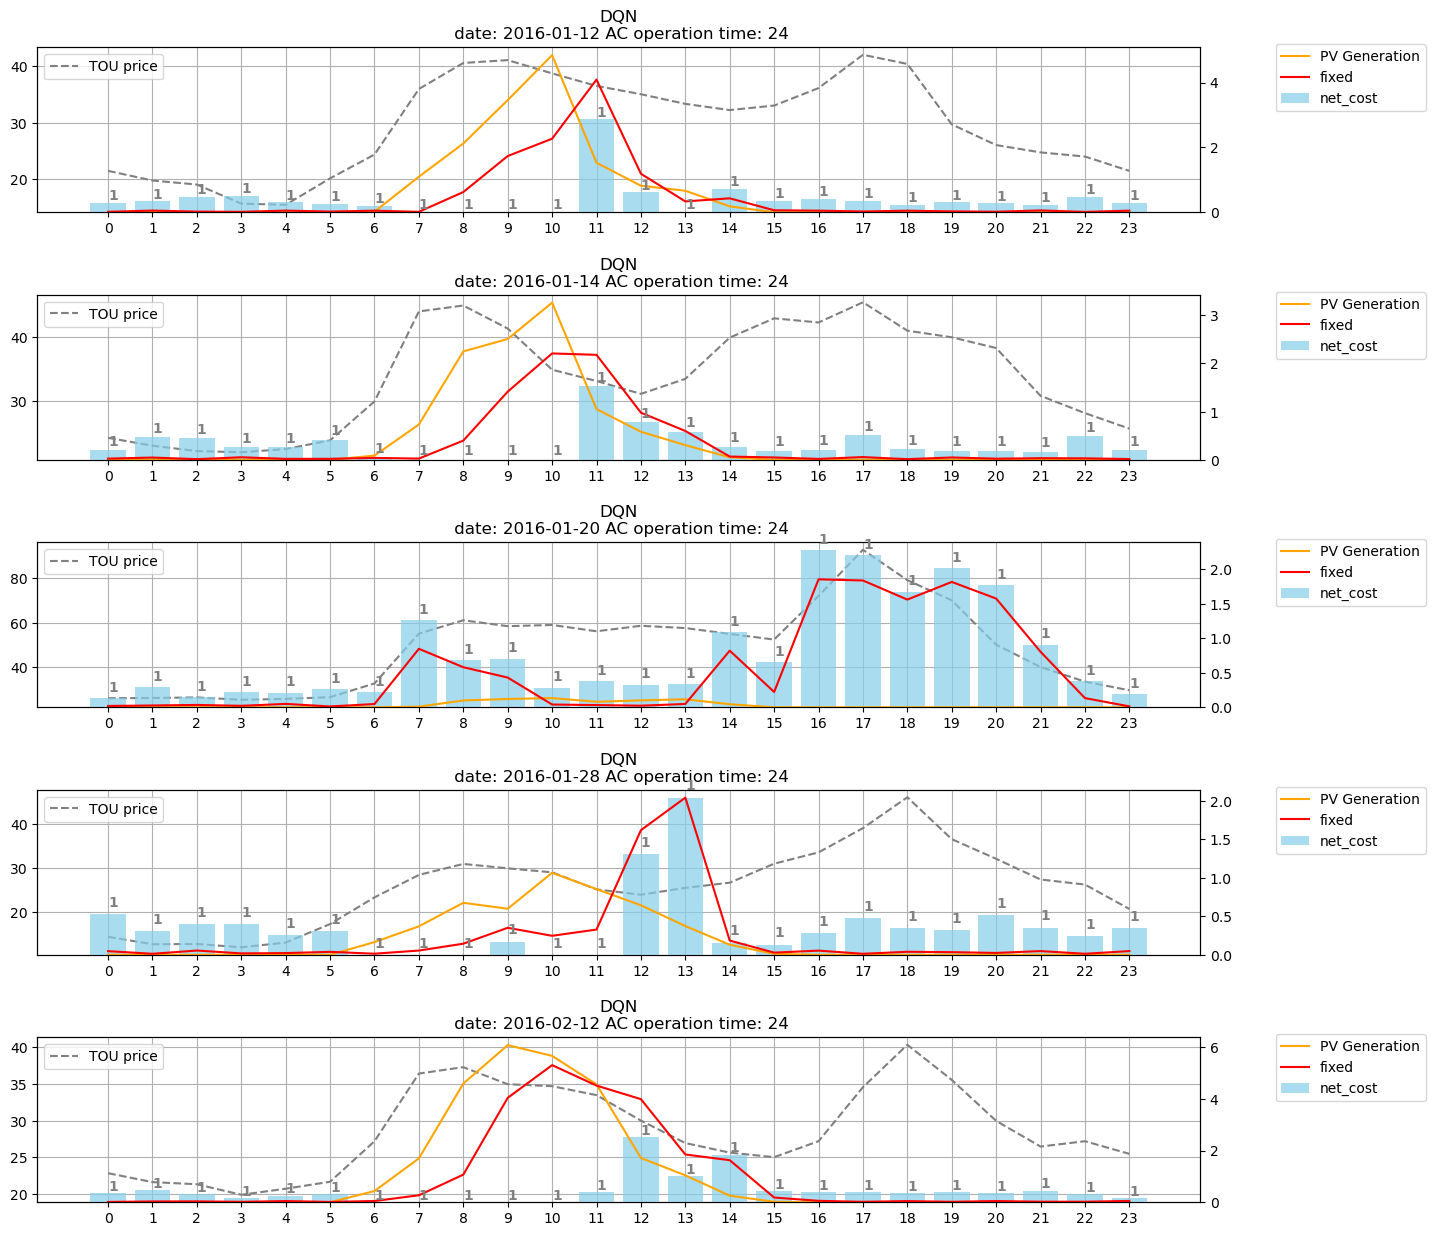

In [23]:
plot_result_price(re=re_dqn_test, method="DQN")

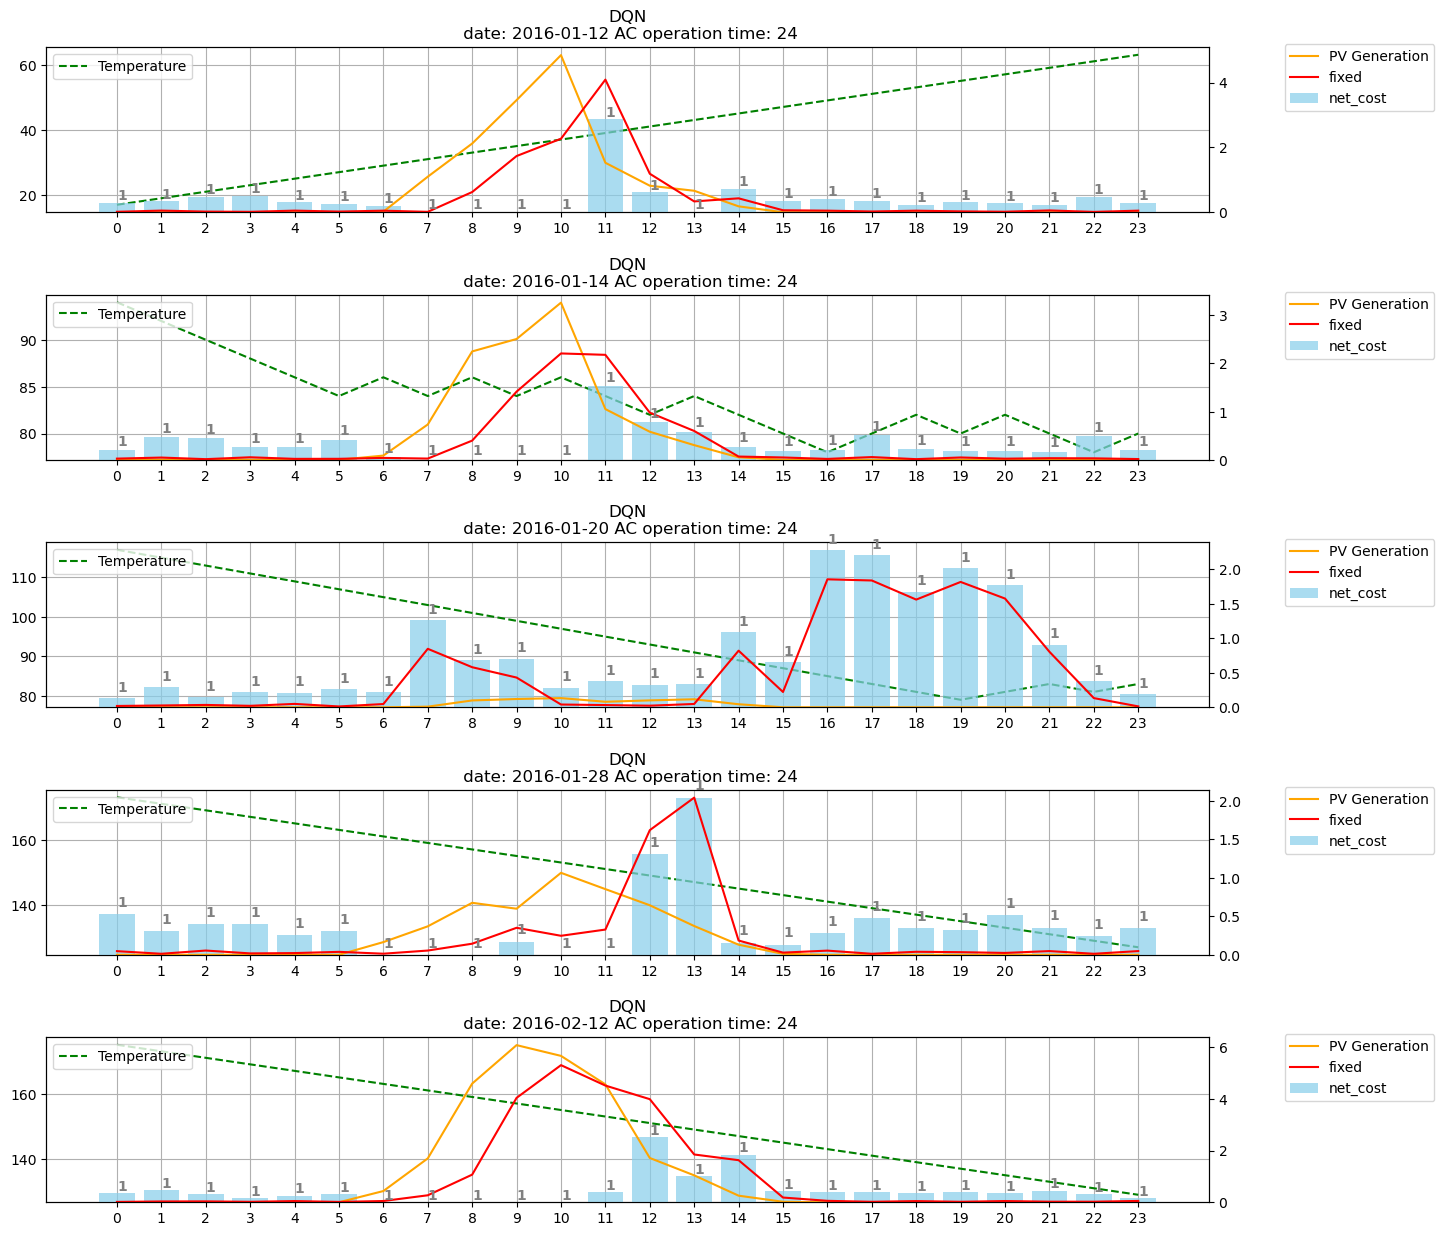

In [24]:
plot_result_temp(re=re_dqn_test, method="DQN")

# A2C

In [25]:
train_env = ACEnv(df=df_train, 
            mode="training",
            penalty_temp=0.2, 
            penalty_energy=0.5, 
            penalty_ope=0.2, 
            prefered_temp_min=80, 
            prefered_temp_max=85, 
            max_limit=1000)

test_env = ACEnv(df=df_test, 
            mode="testing",
            penalty_temp=0.2, 
            penalty_energy=0.5, 
            penalty_ope=0.2, 
            prefered_temp_min=80, 
            prefered_temp_max=85, 
            max_limit=1000)


a2c = A2C("MlpPolicy", train_env, verbose=1)
a2c.learn(total_timesteps=25000)

re_a2c_train = predict(a2c, train_env)
re_a2c_test = predict(a2c, test_env)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 24       |
|    ep_rew_mean        | -625     |
| time/                 |          |
|    fps                | 192      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.5     |
|    explained_variance | 0.000117 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -63.1    |
|    value_loss         | 1.38e+03 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 24        |
|    ep_rew_mean        | -564      |
| time/                 |           |
|    fps                | 193       |
|    iterations         | 200       |
|    time_e

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 24        |
|    ep_rew_mean        | -465      |
| time/                 |           |
|    fps                | 184       |
|    iterations         | 1400      |
|    time_elapsed       | 37        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -0.428    |
|    explained_variance | -4.77e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1399      |
|    policy_loss        | -11.2     |
|    value_loss         | 1.35e+03  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 24        |
|    ep_rew_mean        | -449      |
| time/                 |           |
|    fps                | 184       |
|    iterations         | 1500      |
|    time_elapsed       | 40        |
|    total_timesteps    | 7500      |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 24        |
|    ep_rew_mean        | -489      |
| time/                 |           |
|    fps                | 185       |
|    iterations         | 2700      |
|    time_elapsed       | 72        |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -0.716    |
|    explained_variance | -7.15e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 2699      |
|    policy_loss        | -6.23     |
|    value_loss         | 693       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 24        |
|    ep_rew_mean        | -470      |
| time/                 |           |
|    fps                | 185       |
|    iterations         | 2800      |
|    time_elapsed       | 75        |
|    total_timesteps    | 14000     |
| train/    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 24       |
|    ep_rew_mean        | -470     |
| time/                 |          |
|    fps                | 184      |
|    iterations         | 4000     |
|    time_elapsed       | 108      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -0.146   |
|    explained_variance | 0.074    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 0.885    |
|    value_loss         | 2.94e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 24       |
|    ep_rew_mean        | -496     |
| time/                 |          |
|    fps                | 184      |
|    iterations         | 4100     |
|    time_elapsed       | 110      |
|    total_timesteps    | 20500    |
| train/                |          |
|

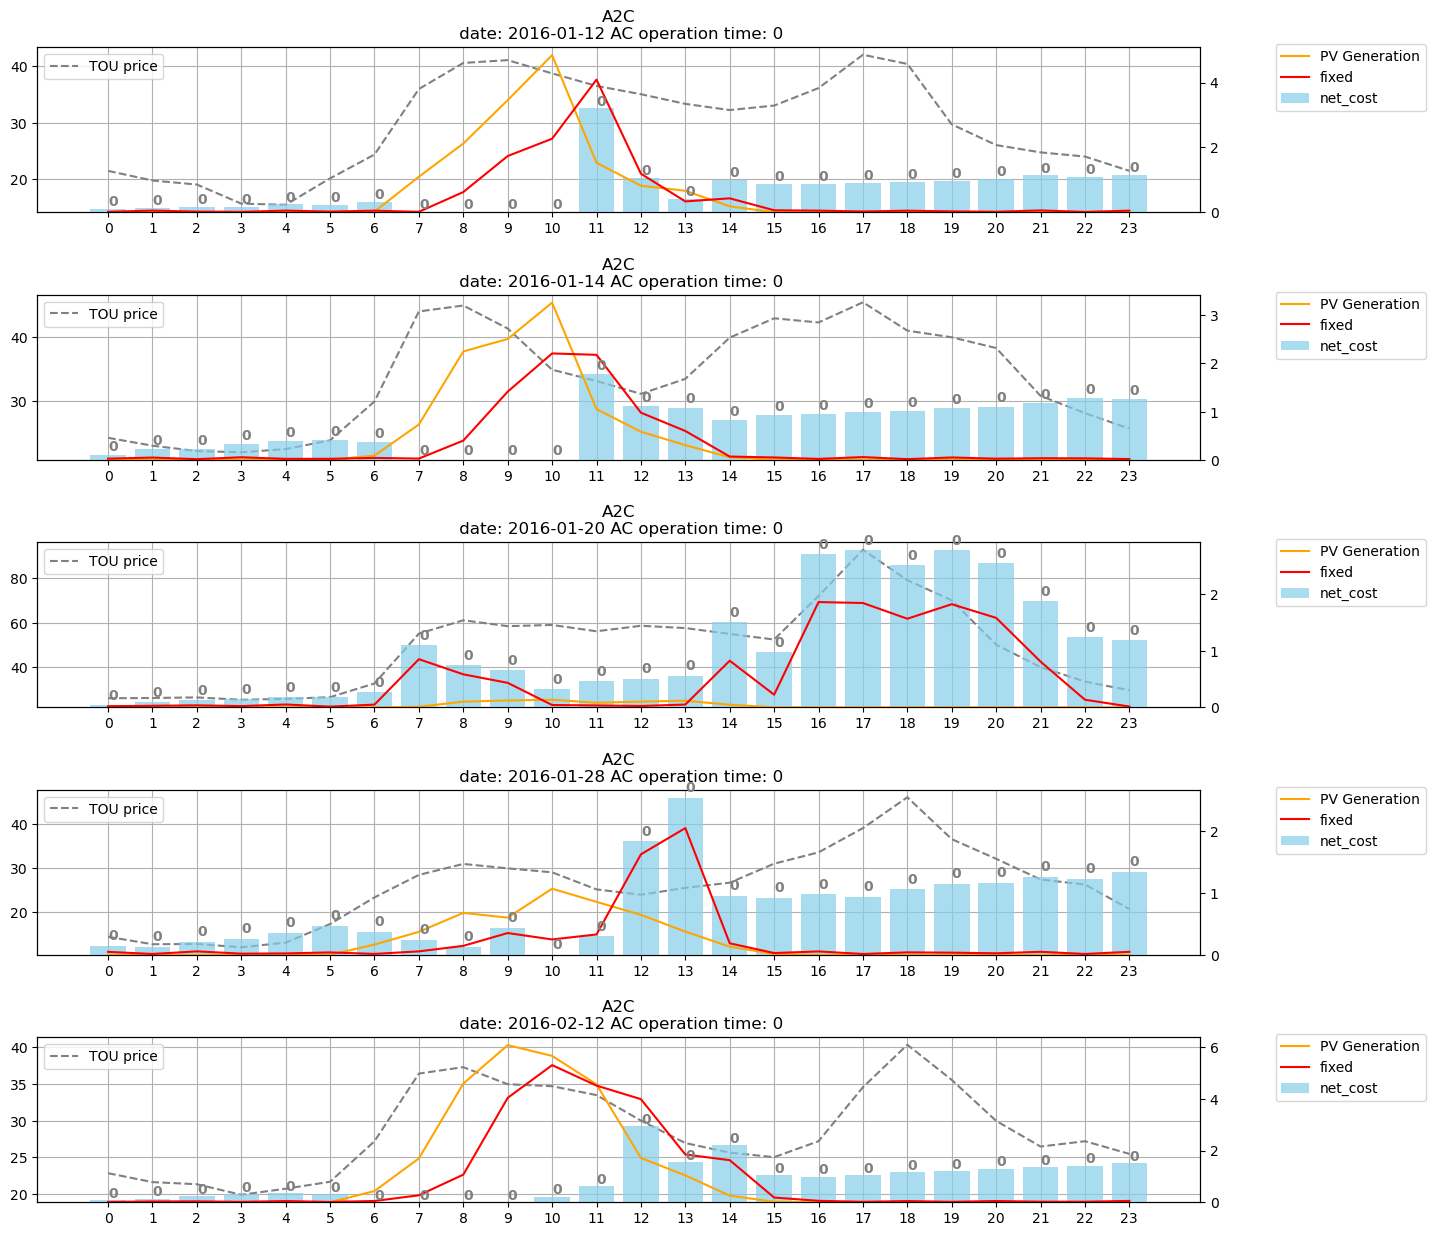

In [26]:
plot_result_price(re=re_a2c_test, method="A2C")

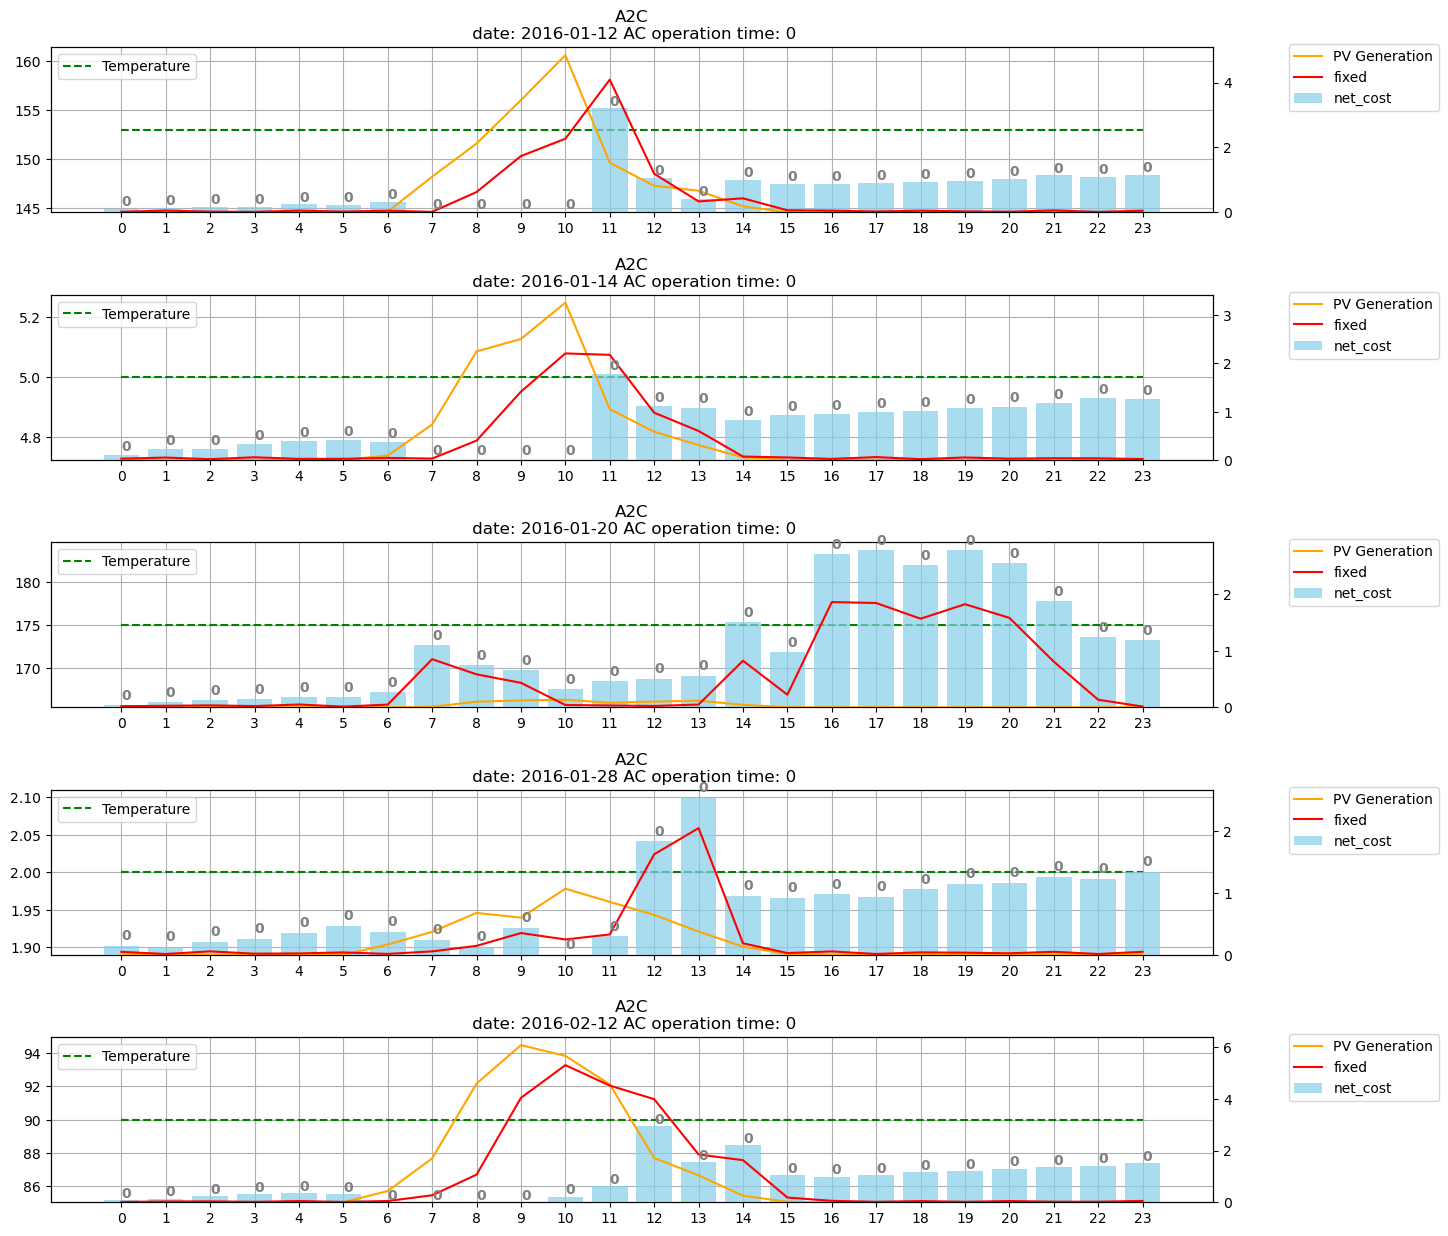

In [27]:
plot_result_temp(re=re_a2c_test, method="A2C")